# Reconstruction MILP

This notebook is needed for the MILP results reconstruction analysis.

Let's first generate a random circuit!



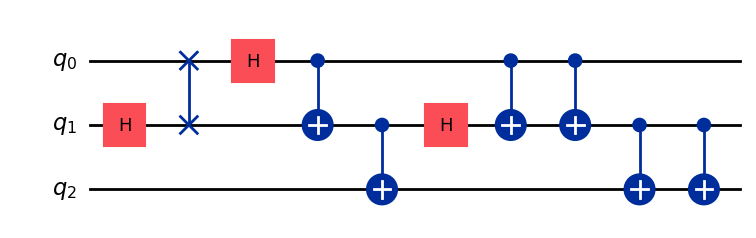

In [25]:
import qiskit.circuit.random
import qiskit
import qiskit.circuit.library.standard_gates
import random

import quariadne.circuit

QUBIT_COUNT = 3
NUM_GATES = 10
SEED = 156

random.seed(SEED)

MAX_OPERANDS = 2

STANDARD_GATE_SET = ["cx", "h", "swap"]



random_circuit = qiskit.QuantumCircuit(QUBIT_COUNT)
for operation_index in range(NUM_GATES):
    random_operation_label = random.choice(STANDARD_GATE_SET)
    if random_operation_label == "h":
        random_qubit = random.randint(0, QUBIT_COUNT-1)
        random_circuit.h(random_qubit)
    else:
        random_qubit_pair_first = random.randint(0, QUBIT_COUNT-2)
        random_qubit_pair_second = random_qubit_pair_first + 1

        if random_operation_label == "cx":
            random_circuit.cx(random_qubit_pair_first, random_qubit_pair_second)
        elif random_operation_label == "swap":
            random_circuit.swap(random_qubit_pair_first, random_qubit_pair_second)

random_circuit.draw('mpl')

Now let's generate random backend coupling map)

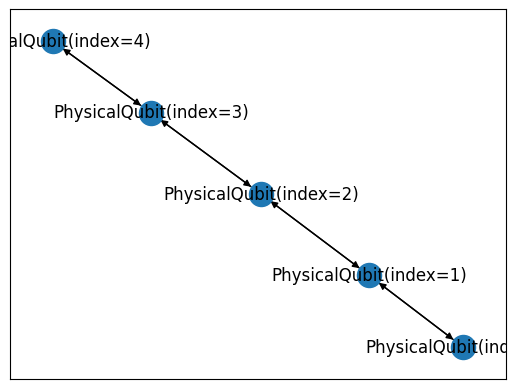

In [26]:
import qiskit_ibm_runtime.fake_provider 
import networkx as nx

manila_backend = qiskit_ibm_runtime.fake_provider.FakeManilaV2()
coupling_graph = manila_backend.coupling_map.graph
coupling_graph_nx = nx.DiGraph()

coupling_map_qubits = manila_backend.coupling_map.physical_qubits
physical_qubits = tuple(quariadne.circuit.PhysicalQubit(coupling_map_qubit) for coupling_map_qubit in coupling_map_qubits)
coupling_map_edgelist = manila_backend.coupling_map.graph.edge_list()
physical_qubits_connections = tuple((quariadne.circuit.PhysicalQubit(coupling_map_from), quariadne.circuit.PhysicalQubit(coupling_map_to)) for coupling_map_from, coupling_map_to in coupling_map_edgelist)
physical_qubits, physical_qubits_connections
coupling_graph_nx.add_nodes_from(physical_qubits)
coupling_graph_nx.add_edges_from(physical_qubits_connections)
nx.draw_networkx(coupling_graph_nx)

Finally, let's see an encapsulated version of the ciurcuti

In [27]:
random_abstract_circuit = quariadne.circuit.AbstractQuantumCircuit.from_qiskit_circuit(random_circuit)
random_abstract_circuit.operations

[QuantumOperation(name='h', qubits_participating=(LogicalQubit(index=1),)),
 QuantumOperation(name='swap', qubits_participating=(LogicalQubit(index=0), LogicalQubit(index=1))),
 QuantumOperation(name='h', qubits_participating=(LogicalQubit(index=0),)),
 QuantumOperation(name='cx', qubits_participating=(LogicalQubit(index=0), LogicalQubit(index=1))),
 QuantumOperation(name='cx', qubits_participating=(LogicalQubit(index=1), LogicalQubit(index=2))),
 QuantumOperation(name='h', qubits_participating=(LogicalQubit(index=1),)),
 QuantumOperation(name='cx', qubits_participating=(LogicalQubit(index=0), LogicalQubit(index=1))),
 QuantumOperation(name='cx', qubits_participating=(LogicalQubit(index=0), LogicalQubit(index=1))),
 QuantumOperation(name='cx', qubits_participating=(LogicalQubit(index=1), LogicalQubit(index=2))),
 QuantumOperation(name='cx', qubits_participating=(LogicalQubit(index=1), LogicalQubit(index=2)))]

Let's initialise the milp router, and run it then!

In [28]:
import quariadne.milp_router

milp_router = quariadne.milp_router.MilpRouter(coupling_graph_nx, random_abstract_circuit)
milp_router_result = milp_router._run_milp()
milp_router_result

logical_uniqueness_constraint (315, 12978) 1 1
physical_uniqueness_constraint (315, 12978) 1 1
gate_execution_constraint (7, 12978) 1 1
gate_mapping_constraint (56, 12978) 0 inf
gate_mapping_left_qubit_constraint (56, 12978) -inf 0
gate_mapping_right_qubit_constraint (56, 12978) -inf 0
gate_mapping_full_qubit_constraint (56, 12978) -1 inf
flow_condition_in_constraint (1550, 12978) 0 0
flow_condition_out_constraint (1575, 12978) 0 0


        message: Optimization terminated successfully. (HiGHS Status 7: Optimal)
        success: True
         status: 0
            fun: 0.0
              x: [ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]
 mip_node_count: 1
 mip_dual_bound: 0.0
        mip_gap: 0.0

Let's reconstruct the mapping patterns then, and check that they are consistent. Maybe it is a better idea though to find the places where the swaps happen. 

In [29]:
import numpy as np

reconstructed_movement_variables = np.zeros(milp_router.qubit_movement_shape)
movement_starting_index = milp_router.flat_mapping_variables_shape + milp_router.flat_gate_execution_variables_shape
movement_ending_index = len(milp_router_result.x)

for movement_idx in range(movement_starting_index, movement_ending_index):
    true_movement_index = movement_idx-movement_starting_index
    qubit_movement_position = np.unravel_index(true_movement_index, milp_router.qubit_movement_shape)
    reconstructed_movement_variables[qubit_movement_position] = milp_router_result.x[movement_idx]


reconstructed_movement_variables

array([[[[-0.,  0.,  0.,  0.,  0.],
         [ 0., -0.,  0.,  0.,  0.],
         [ 0.,  0., -0.,  0.,  0.],
         [ 0.,  0.,  0., -0.,  0.],
         [ 0.,  0.,  0.,  0.,  1.]],

        [[-0.,  0.,  0.,  0.,  0.],
         [ 0., -0.,  0.,  0.,  0.],
         [ 0.,  0., -0.,  0.,  0.],
         [ 0.,  0.,  0.,  1.,  0.],
         [ 0.,  0.,  0.,  0., -0.]],

        [[-0.,  0.,  0.,  0.,  0.],
         [ 0., -0.,  0.,  0.,  0.],
         [ 0.,  0.,  1.,  0.,  0.],
         [ 0.,  0.,  0., -0.,  0.],
         [ 0.,  0.,  0.,  0., -0.]],

        [[ 1.,  0.,  0.,  0.,  0.],
         [ 0., -0.,  0.,  0.,  0.],
         [ 0.,  0., -0.,  0.,  0.],
         [ 0.,  0.,  0., -0.,  0.],
         [ 0.,  0.,  0.,  0., -0.]],

        [[-0.,  0.,  0.,  0.,  0.],
         [ 0.,  1.,  0.,  0.,  0.],
         [ 0.,  0., -0.,  0.,  0.],
         [ 0.,  0.,  0., -0.,  0.],
         [ 0.,  0.,  0.,  0., -0.]]],


       [[[-0.,  0.,  0.,  0.,  0.],
         [ 0., -0.,  0.,  0.,  0.],
         [ 0.,  

And let's see if there is any swaps?

In [30]:
defined_movements = np.argwhere(reconstructed_movement_variables)
for movement in defined_movements:
    timestep, logical_qubit, from_qubit, to_qubit = movement
    if from_qubit != to_qubit:
        print(movement)

No swaps! Let's generate another circuit then, and check it as well. 

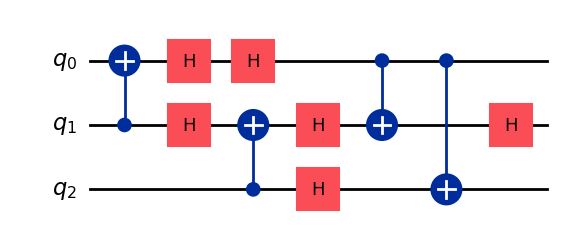

In [31]:
import random
import qiskit.circuit.random

QUBIT_COUNT = 3
NUM_GATES = 10
#SEED = 222
SEED=223
random.seed(SEED)

MAX_OPERANDS = 2

STANDARD_GATE_SET = ["cx", "h"]



random_broken_circuit = qiskit.circuit.random.random_clifford_circuit(QUBIT_COUNT, NUM_GATES, STANDARD_GATE_SET, seed=SEED)

random_broken_circuit.draw('mpl')

Perfect! Let's run the router then!

In [32]:
random_broken_abstract_circuit = quariadne.circuit.AbstractQuantumCircuit.from_qiskit_circuit(random_broken_circuit)
milp_broken_router = quariadne.milp_router.MilpRouter(coupling_graph_nx, random_broken_abstract_circuit)
milp_broken_router_result = milp_broken_router._run_milp()
milp_broken_router_result

logical_uniqueness_constraint (180, 6552) 1 1
physical_uniqueness_constraint (180, 6552) 1 1
gate_execution_constraint (4, 6552) 1 1
gate_mapping_constraint (32, 6552) 0 inf
gate_mapping_left_qubit_constraint (32, 6552) -inf 0
gate_mapping_right_qubit_constraint (32, 6552) -inf 0
gate_mapping_full_qubit_constraint (32, 6552) -1 inf
flow_condition_in_constraint (875, 6552) 0 0
flow_condition_out_constraint (900, 6552) 0 0


        message: Optimization terminated successfully. (HiGHS Status 7: Optimal)
        success: True
         status: 0
            fun: 0.9999999999999999
              x: [ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]
 mip_node_count: 1
 mip_dual_bound: 0.9999999999999999
        mip_gap: 0.0

Sometimes the rounding error happen, so we will purge them down by the rounding operation. 

In [33]:
milp_broken_result_variables = np.rint(milp_broken_router_result.x)
milp_broken_result_variables

array([0., 0., 0., ..., 0., 0., 0.], shape=(6552,))

In [34]:
random_broken_abstract_circuit

AbstractQuantumCircuit(operations=[QuantumOperation(name='cx', qubits_participating=(LogicalQubit(index=1), LogicalQubit(index=0))), QuantumOperation(name='h', qubits_participating=(LogicalQubit(index=1),)), QuantumOperation(name='h', qubits_participating=(LogicalQubit(index=0),)), QuantumOperation(name='cx', qubits_participating=(LogicalQubit(index=2), LogicalQubit(index=1))), QuantumOperation(name='h', qubits_participating=(LogicalQubit(index=0),)), QuantumOperation(name='h', qubits_participating=(LogicalQubit(index=2),)), QuantumOperation(name='h', qubits_participating=(LogicalQubit(index=1),)), QuantumOperation(name='cx', qubits_participating=(LogicalQubit(index=0), LogicalQubit(index=1))), QuantumOperation(name='cx', qubits_participating=(LogicalQubit(index=0), LogicalQubit(index=2))), QuantumOperation(name='h', qubits_participating=(LogicalQubit(index=1),))], qubits=(LogicalQubit(index=0), LogicalQubit(index=1), LogicalQubit(index=2)))

Okay, let's reconstruct the solution, and check if everything is coherent. 

In [35]:
import numpy as np

reconstructed_movement_variables = np.zeros(milp_broken_router.qubit_movement_shape)
movement_starting_index = milp_broken_router.flat_mapping_variables_shape + milp_broken_router.flat_gate_execution_variables_shape
movement_ending_index = len(milp_broken_result_variables)

for movement_idx in range(movement_starting_index, movement_ending_index):
    true_movement_index = movement_idx-movement_starting_index
    qubit_movement_position = np.unravel_index(true_movement_index, milp_broken_router.qubit_movement_shape)
    reconstructed_movement_variables[qubit_movement_position] = milp_broken_result_variables[movement_idx]


reconstructed_movement_variables

array([[[[ 0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.],
         [ 0.,  0., -0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  1.]],

        [[ 0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  1.,  0.],
         [ 0.,  0.,  0.,  0.,  0.]],

        [[ 0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  1.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0., -0.]],

        [[ 0.,  0.,  0.,  0.,  0.],
         [ 0.,  1.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0., -0.]],

        [[ 1.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.]]],


       [[[ 0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.],
         [ 0.,  

Detecting all the movements then :sunglasses:

In [36]:
defined_movements = np.argwhere(reconstructed_movement_variables)
for movement in defined_movements:
    timestep, logical_qubit, from_qubit, to_qubit = movement
    if from_qubit != to_qubit:
        print(movement)

[23  1  3  2]
[23  2  2  3]


Okay, I'll check also the reconstructed mappings and the reconstructed gate execution, to see if everything is consistent.

In [37]:
reconstructed_gate_execution = np.zeros(milp_broken_router.gate_execution_variables_shape)
execution_starting_index = milp_broken_router.flat_mapping_variables_shape
execution_ending_index = milp_broken_router.flat_mapping_variables_shape + milp_broken_router.flat_gate_execution_variables_shape

for execution_index in range(execution_starting_index, execution_ending_index):
    gate_execution_position = np.unravel_index(execution_index-execution_starting_index, milp_broken_router.gate_execution_variables_shape)
    reconstructed_gate_execution[gate_execution_position] = milp_broken_result_variables[execution_index]


reconstructed_gate_execution

array([[[ 0.,  0.,  0., ..., -0.,  1.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]],

       [[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]],

       [[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]],

       ...,

       [[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]],

       [[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]],

       [[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.

And the corresponding executions are:

In [38]:
defined_executions = np.argwhere(reconstructed_gate_execution)
for execution in defined_executions:
    timestep, operation_idx, edge_idx = execution
    print(execution, reconstructed_gate_execution[timestep], list(coupling_graph_nx.edges())[edge_idx])

[0 0 6] [[ 0.  0.  0.  0. -0. -0.  1.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]] (PhysicalQubit(index=3), PhysicalQubit(index=4))
[9 1 4] [[ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  1.  0.  0. -0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]] (PhysicalQubit(index=2), PhysicalQubit(index=3))
[18  2  7] [[ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0. -0.  0.  0.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]] (PhysicalQubit(index=4), PhysicalQubit(index=3))
[27  3  7] [[ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0. -0.  0.  0.  1.]] (PhysicalQubit(index=4), PhysicalQubit(index=3))


Now let's check the final, the mappings, and go to the backend part!

In [39]:
reconstructed_mapping = np.zeros(milp_broken_router.mapping_variables_shape)
mapping_starting_index = 0
mapping_ending_index = milp_broken_router.flat_mapping_variables_shape

for mapping_index in range(mapping_starting_index, mapping_ending_index):
    mapping_position = np.unravel_index(mapping_index-mapping_starting_index, milp_broken_router.mapping_variables_shape)
    reconstructed_mapping[mapping_position] = milp_broken_result_variables[mapping_index]


reconstructed_mapping

array([[[ 0.,  0.,  0.,  0.,  1.],
        [ 0.,  0.,  0.,  1.,  0.],
        [-0.,  0.,  1.,  0.,  0.],
        [ 0.,  1.,  0.,  0.,  0.],
        [ 1.,  0., -0., -0.,  0.]],

       [[ 0.,  0.,  0.,  0.,  1.],
        [ 0.,  0.,  0.,  1.,  0.],
        [-0.,  0.,  1.,  0.,  0.],
        [ 0.,  1.,  0.,  0.,  0.],
        [ 1.,  0., -0., -0.,  0.]],

       [[ 0.,  0.,  0.,  0.,  1.],
        [ 0.,  0.,  0.,  1.,  0.],
        [-0.,  0.,  1.,  0.,  0.],
        [ 0.,  1.,  0.,  0.,  0.],
        [ 1.,  0., -0., -0.,  0.]],

       [[ 0.,  0.,  0.,  0.,  1.],
        [ 0.,  0.,  0.,  1.,  0.],
        [-0.,  0.,  1.,  0.,  0.],
        [ 0.,  1.,  0.,  0.,  0.],
        [ 1.,  0., -0., -0.,  0.]],

       [[ 0.,  0.,  0.,  0.,  1.],
        [ 0.,  0.,  0.,  1.,  0.],
        [-0.,  0.,  1.,  0.,  0.],
        [ 0.,  1.,  0.,  0.,  0.],
        [ 1.,  0., -0., -0.,  0.]],

       [[ 0.,  0.,  0.,  0.,  1.],
        [ 0.,  0.,  0.,  1.,  0.],
        [-0.,  0.,  1.,  0.,  0.],
        [ 

Checking the actual mappings!

In [40]:
defined_mappings = np.argwhere(reconstructed_mapping)
for mapping in defined_mappings:
    timestep, physical_idx, logical_idx = mapping
    print(mapping)

[0 0 4]
[0 1 3]
[0 2 2]
[0 3 1]
[0 4 0]
[1 0 4]
[1 1 3]
[1 2 2]
[1 3 1]
[1 4 0]
[2 0 4]
[2 1 3]
[2 2 2]
[2 3 1]
[2 4 0]
[3 0 4]
[3 1 3]
[3 2 2]
[3 3 1]
[3 4 0]
[4 0 4]
[4 1 3]
[4 2 2]
[4 3 1]
[4 4 0]
[5 0 4]
[5 1 3]
[5 2 2]
[5 3 1]
[5 4 0]
[6 0 4]
[6 1 3]
[6 2 2]
[6 3 1]
[6 4 0]
[7 0 4]
[7 1 3]
[7 2 2]
[7 3 1]
[7 4 0]
[8 0 4]
[8 1 3]
[8 2 2]
[8 3 1]
[8 4 0]
[9 0 4]
[9 1 3]
[9 2 2]
[9 3 1]
[9 4 0]
[10  0  4]
[10  1  3]
[10  2  2]
[10  3  1]
[10  4  0]
[11  0  4]
[11  1  3]
[11  2  2]
[11  3  1]
[11  4  0]
[12  0  4]
[12  1  3]
[12  2  2]
[12  3  1]
[12  4  0]
[13  0  4]
[13  1  3]
[13  2  2]
[13  3  1]
[13  4  0]
[14  0  4]
[14  1  3]
[14  2  2]
[14  3  1]
[14  4  0]
[15  0  4]
[15  1  3]
[15  2  2]
[15  3  1]
[15  4  0]
[16  0  4]
[16  1  3]
[16  2  2]
[16  3  1]
[16  4  0]
[17  0  4]
[17  1  3]
[17  2  2]
[17  3  1]
[17  4  0]
[18  0  4]
[18  1  3]
[18  2  2]
[18  3  1]
[18  4  0]
[19  0  4]
[19  1  3]
[19  2  2]
[19  3  1]
[19  4  0]
[20  0  4]
[20  1  3]
[20  2  2]
[20  3  1]
[20  4

Let's write the function for the initial mapping stage then!

In [41]:
initial_mapping = np.argwhere(reconstructed_mapping[0])
initial_mapping_casted = initial_mapping.tolist()
physical_by_logical_initial_mapping = {quariadne.circuit.LogicalQubit(logical_idx): quariadne.circuit.PhysicalQubit(physical_idx) for physical_idx, logical_idx in initial_mapping_casted}
physical_by_logical_initial_mapping

{LogicalQubit(index=4): PhysicalQubit(index=0),
 LogicalQubit(index=3): PhysicalQubit(index=1),
 LogicalQubit(index=2): PhysicalQubit(index=2),
 LogicalQubit(index=1): PhysicalQubit(index=3),
 LogicalQubit(index=0): PhysicalQubit(index=4)}

Let's try to see the locations of the swaps, and add them to the operations list I guess? Or identify how to position them, it is not as easy as it seems. 

In [42]:
import collections

WORST_SPACING = 3 ** 2
swap_pairs_by_timestep = collections.defaultdict(list)
defined_movements = np.argwhere(reconstructed_movement_variables)
for movement in defined_movements:
    timestep, logical_qubit, from_qubit, to_qubit = movement.tolist()
    swap_pair = frozenset((from_qubit, to_qubit,))
    if from_qubit != to_qubit:
        current_timestep_swaps = swap_pairs_by_timestep[timestep // WORST_SPACING + 1]
        if swap_pair not in current_timestep_swaps:
            current_timestep_swaps.append(swap_pair)

swap_pairs_by_timestep

defaultdict(list, {3: [frozenset({2, 3})]})

Great, moving to the closing of the thing, and transpiling the stuff. 

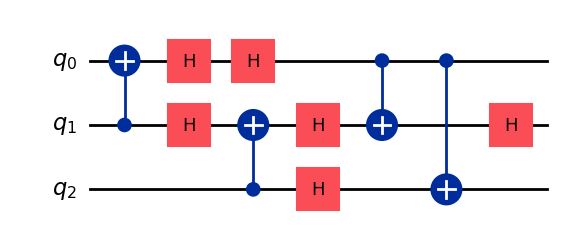

In [43]:
from qiskit.transpiler import generate_preset_pass_manager

random_broken_circuit.draw("mpl")

Beautiful. Let's then look into the transpiler, especially the routing engine itself.  Let's start with the layout decomposition anyway.

logical_uniqueness_constraint (180, 6552) 1 1
physical_uniqueness_constraint (180, 6552) 1 1
gate_execution_constraint (4, 6552) 1 1
gate_mapping_constraint (32, 6552) 0 inf
gate_mapping_left_qubit_constraint (32, 6552) -inf 0
gate_mapping_right_qubit_constraint (32, 6552) -inf 0
gate_mapping_full_qubit_constraint (32, 6552) -1 inf
flow_condition_in_constraint (875, 6552) 0 0
flow_condition_out_constraint (900, 6552) 0 0
{'contains_switch_case': False, 'contains_for_loop': False, 'contains_if_else': False, 'contains_while_loop': False, 'contains_box': False, 'milp_result': MilpRouterResult(milp_result=        message: Optimization terminated successfully. (HiGHS Status 7: Optimal)
        success: True
         status: 0
            fun: 0.9999999999999999
              x: [ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]
 mip_node_count: 1
 mip_dual_bound: 0.9999999999999999
        mip_gap: 0.0, mapping_variables=array([[[ 0.,  0.,  0.,  0.,  1.],
        [ 0.,  0.,  0.,  1.,  0.],
 

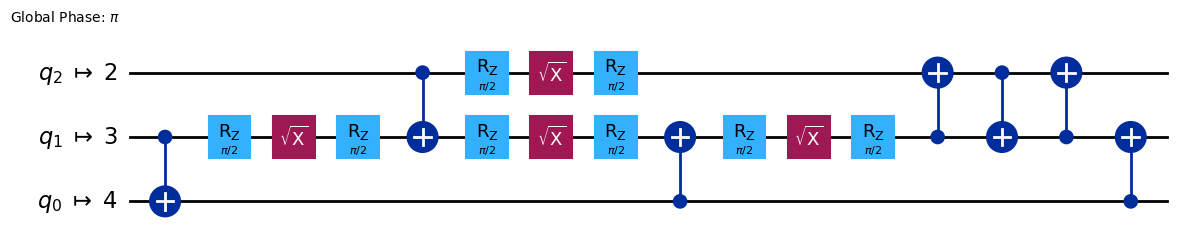

In [44]:
import quariadne.computational_graph

class MilpLayout(qiskit.transpiler.AnalysisPass):

    def __init__(self, coupling_map):
        super().__init__()
        if isinstance(coupling_map, qiskit.transpiler.Target):
            self.target = coupling_map
            self.coupling_map = self.target.build_coupling_map()
        else:
            self.target = None
            self.coupling_map = coupling_map

    def run(self, dag):
        """Run the TrivialLayout pass on `dag`.

        Args:
            dag (DAGCircuit): DAG to find layout for.

        Raises:
            TranspilerError: if dag wider than the target backend
        """
        if self.target is not None:
            if dag.num_qubits() > self.target.num_qubits:
                raise TranspilerError("Number of qubits greater than device.")
        elif dag.num_qubits() > self.coupling_map.size():
            raise TranspilerError("Number of qubits greater than device.")

        quariadne_dag = quariadne.computational_graph.ComputationalDAG.from_qiskit_dag(dag)
        quariadne_circuit = quariadne_dag.to_abstract_quantum_circuit()
        coupling_graph = quariadne.milp_router.get_coupling_graph(self.coupling_map)
        milp_broken_router = quariadne.milp_router.MilpRouter(coupling_graph, quariadne_circuit)
        milp_broken_router_result = milp_broken_router.run()
        self.property_set["milp_result"] = milp_broken_router_result

        physical_by_logical_initial_mapping = milp_broken_router_result.initial_mapping
        
        layout_intlist = []

        for logical_qubit in sorted(physical_by_logical_initial_mapping.keys(), key=lambda qubit: qubit.index):
            if logical_qubit.index >= len(dag.qubits):
                continue
            physical_qubit = physical_by_logical_initial_mapping[logical_qubit]
            layout_intlist.append(physical_qubit.index)
        
        
        print(self.property_set)

        canonical_register = dag.qregs["q"]

        milp_layout = qiskit.transpiler.Layout.from_intlist(layout_intlist, canonical_register)
        self.property_set["layout"] = milp_layout

class MilpRouting(qiskit.transpiler.TransformationPass):

    def __init__(self, coupling_map):
        super().__init__()

        self.coupling_map = coupling_map
        


    
    def run(self, dag):
        
        print(self.property_set["layout"], self.property_set["final_layout"])

        new_dag = dag.copy_empty_like()

        if self.coupling_map is None:
            raise TranspilerError("BasicSwap cannot run with coupling_map=None")

        if len(dag.qregs) != 1 or dag.qregs.get("q", None) is None:
            raise TranspilerError("Basic swap runs on physical circuits only")

        if len(dag.qubits) > len(self.coupling_map.physical_qubits):
            raise TranspilerError("The layout does not match the amount of qubits in the DAG")


        canonical_register = dag.qregs["q"]


        milp_broken_router_result = self.property_set["milp_result"]
        swap_pairs_by_timestep = milp_broken_router_result.inserted_swaps


        trivial_layout = qiskit.transpiler.Layout.generate_trivial_layout(canonical_register)
        current_layout = trivial_layout.copy()

        layer_idx = 0
        for layer in dag.serial_layers():
            
            subdag = layer["graph"]
            for gate in subdag.two_qubit_ops():

                if layer_idx in swap_pairs_by_timestep:
    
                    for swap in swap_pairs_by_timestep[layer_idx]:
                        # Insert a new layer with the SWAP(s).
                        swap_layer = qiskit.dagcircuit.DAGCircuit()
                        swap_layer.add_qreg(canonical_register)    
                        physical_qubit_1, physical_qubit_2 = swap.first.index, swap.second.index               
                        qubit_1, qubit_2 = current_layout[physical_qubit_1], current_layout[physical_qubit_2]
                        print(qubit_1, qubit_2)
                        # create the swap operation
                        
                        swap_layer.apply_operation_back(
                            qiskit.circuit.library.SwapGate(), (qubit_1, qubit_2), cargs=(), check=False
                        )
                        # layer insertion
                        order = current_layout.reorder_bits(new_dag.qubits)
                        new_dag.compose(swap_layer, qubits=order)
    
                    # update current_layout
                    for swap in swap_pairs_by_timestep[layer_idx]:
                        physical_qubit_1, physical_qubit_2 = swap.first.index, swap.second.index
                        current_layout.swap(physical_qubit_1, physical_qubit_2)
                layer_idx += 1

            order = current_layout.reorder_bits(new_dag.qubits)
            
            new_dag.compose(subdag, qubits=order)

        if self.property_set["final_layout"] is None:
            self.property_set["final_layout"] = current_layout
        else:
            # The "final layout" can be thought of as a "comes from" permutation that you apply at
            # the end of the circuit to invert the routing.  So if there's an existing one, what we
            # apply at the end of the circuit needs to set the circuit qubits so they "come from"
            # the previous one, then those "come from" the one we've just added.
            self.property_set["final_layout"] = self.property_set["final_layout"].compose(
                current_layout, dag.qubits
            )
        print(self.property_set["layout"], self.property_set["final_layout"])
        return new_dag        

        
milp_layout_pass = MilpLayout(manila_backend.coupling_map)
pm_empty = qiskit.transpiler.PassManager([milp_layout_pass])
pm_empty += qiskit.transpiler.preset_passmanagers.generate_embed_passmanager(manila_backend.coupling_map)

milp_routing_pass = MilpRouting(manila_backend.coupling_map)
milp_routing_pm = qiskit.transpiler.PassManager([milp_routing_pass])

basis_passmanager = qiskit.transpiler.generate_preset_pass_manager(backend=manila_backend, optimization_level=3, routing_method="basic", layout_method="trivial")

basis_passmanager.layout = pm_empty
basis_passmanager.routing = milp_routing_pm

physical = basis_passmanager.run(random_broken_circuit)
physical.draw("mpl")

And let's check its result. 

In [45]:
from qiskit_ibm_runtime import QiskitRuntimeService, Session
from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit_ibm_runtime import EstimatorV2 as Estimator
 
with Session(backend=manila_backend) as session:
    # Submit a request to the Sampler primitive within the session.
    sampler = Sampler(mode=session)
    job = sampler.run([physical])
    pub_result = job.result()[0]
    print(pub_result)
 

No classical registers in circuit "circuit-172-175", counts will be empty.


SamplerPubResult(data=DataBin(), metadata={'shots': 1024, 'circuit_metadata': {}})


Great, we made the plugin for the thing, hooray! Let's wrap it up with some moved functionality. 